<a href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/content/word_embeddings_sentiment_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 George Mihaila.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GPUs in Natural Language Processing


<td>
    <a target="_blank" href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/sentiment_clustering.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/gtc2020_instructor_training.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Train custom word embeddings using a small Neural Network.
 * Use Lime to explain model predictions.
 * Use the embedding model to create review embeddings.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Notebook Environment Sanity Check

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4 or P100.

[source](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD)

In [2]:
## VERSION CHECK
!nvidia-smi
!nvcc -V
!python -V; pip -V

Fri Feb 14 03:23:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

* Set up script installs for [Rapids](https://rapids.ai):

  1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
  1. removes incompatible files
  1. Install RAPIDS libraries
  1. Set necessary environment variables
  1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
  1. Recommend select v0.10.

In [3]:
import sys, os
from IPython.display import clear_output

# Install RAPIDS
!rm rapids-colab.sh
!wget -nc https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
!bash rapids-colab.sh

dist_package_index = sys.path.index("/usr/local/lib/python3.6/dist-packages")
sys.path = sys.path[:dist_package_index] + ["/usr/local/lib/python3.6/site-packages"] + sys.path[dist_package_index:]
sys.path
if os.path.exists('update_pyarrow.py'): ## This file only exists if you're using RAPIDS version 0.11 or higher
  exec(open("update_pyarrow.py").read(), globals())
clear_output(wait=True)

rm: cannot remove 'rapids-colab.sh': No such file or directory
--2020-02-14 03:23:19--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5286 (5.2K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   5.16K  --.-KB/s    in 0s      

2020-02-14 03:23:20 (142 MB/s) - ‘rapids-colab.sh’ saved [5286/5286]

PLEASE READ
********************************************************************************************************
Colab v0.11+ Migration Notice:
 
There has been a NECESSARY Colab script code change for VERSION 0.11+ that MAY REQUIRE an update how you install RAPIDS into Colab!  
Not all Colab notebooks

In [4]:
!pip uninstall cffi -y
!sudo apt-get install python-cffi
clear_output(wait=True)

Found existing installation: cffi 1.13.2
Uninstalling cffi-1.13.2:
  Successfully uninstalled cffi-1.13.2
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-cffi-backend python-ply python-pycparser
Suggested packages:
  python-ply-doc python-pkg-resources
The following NEW packages will be installed:
  python-cffi python-cffi-backend python-ply python-pycparser
0 upgraded, 4 newly installed, 0 to remove and 25 not upgraded.
Need to get 245 kB of archives.
After this operation, 1,349 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-cffi-backend amd64 1.11.5-1 [63.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-ply all 3.11-1 [46.6 kB]
Get:3 http://archive.ubuntu.com/

In [5]:
# install sentence transfomers
!pip install git+https://github.com/arvkevi/kneed # for graph knee detection
!pip install git+https://github.com/UKPLab/sentence-transformers
!pip install lime

clear_output(wait=True)

  Cloning https://github.com/arvkevi/kneed to /tmp/pip-req-build-udvhbxqi
  Running command git clone -q https://github.com/arvkevi/kneed /tmp/pip-req-build-udvhbxqi
     |████████████████████████████████| 13.1 MB 2.9 MB/s 
     |████████████████████████████████| 7.0 MB 56.2 MB/s 
     |████████████████████████████████| 26.1 MB 13 kB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 90 kB 13.0 MB/s 
     |████████████████████████████████| 294 kB 100.7 MB/s 
  Created wheel for kneed: filename=kneed-0.5.3-py2.py3-none-any.whl size=10206 sha256=2cd7ec2fbcafe5248092f28f92807ed109e5c0c78cf17e393c9edc36dc9c35ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-th1srw1l/wheels/34/1e/5b/8fccab4811880902601d6770c8af716cde606d78a033ac84fb
Successfully built kneed


  Cloning https://github.com/UKPLab/sentence-transformers to /tmp/pip-req-build-iineyo9r
  Running command git clone -q https://github.com/UKPLab/sentence-transformers /tmp/pip-req-build-iineyo9r
     |████████████████████████████████| 447 kB 2.9 MB/s 
     |████████████████████████████████| 59 kB 8.4 MB/s 
     |████████████████████████████████| 753.4 MB 13 kB/s 
     |████████████████████████████████| 1.5 MB 50.0 MB/s 
     |████████████████████████████████| 128 kB 69.6 MB/s 
     |████████████████████████████████| 1.0 MB 63.4 MB/s 
     |████████████████████████████████| 689 kB 66.0 MB/s 
     |████████████████████████████████| 860 kB 60.0 MB/s 
     |████████████████████████████████| 5.9 MB 58.9 MB/s 
     |████████████████████████████████| 69 kB 10.8 MB/s 
     |████████████████████████████████| 81 kB 13.6 MB/s 
     |████████████████████████████████| 547 kB 80.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.5-py3-none-any.whl size=69891 sha25

### Downloads

In [6]:
if not os.path.exists('imdb_reviews_all_labeled.csv'):
  # IMDB movie reviews
  !wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/imdb_reviews_all_labeled.csv
# if not os.path.exists('yelp_academic_dataset_review.pickle'):
  # yelp reviews
  # !wget https://s3-us-west-2.amazonaws.com/science-of-science-bucket/yelp_academic_dataset/yelp_academic_dataset_review.pickle

--2020-02-14 03:32:46--  https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/imdb_reviews_all_labeled.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/data/imdb_reviews_all_labeled.csv [following]
--2020-02-14 03:32:46--  https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/data/imdb_reviews_all_labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65862311 (63M) [text/plain]
Saving to: ‘imdb_reviews_all_labeled.csv’

imdb_reviews_all_la 100%[===================>]  62.81M   173MB/s    in 0.4s    

2020-0

### Imports

In [35]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
import cudf
from cuml import KMeans
from cuml import PCA as cuPCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

os.environ['NUMBAPRO_NVVM']='/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so'  
os.environ['NUMBAPRO_LIBDEVICE']='/usr/local/cuda-10.0/nvvm/libdevice'

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Functions

In [0]:
def read_yelp_reviews(filename):
  tmp_df = pd.read_pickle(filename)
  yelp_reviews_texts = tmp_df['text'].values
  yelp_reviews_stars = tmp_df['stars'].values
  return yelp_reviews_texts, yelp_reviews_stars


def context_embedding(text, name_of_model, batch_size=1000, use_device="cuda"):
  embed_model = SentenceTransformer(model_name_or_path=name_of_model,
                                    device=torch.device(use_device))
  encodings_text = embed_model.encode(sentences=text, 
                                          batch_size=batch_size, 
                                          show_progress_bar=True)
  # empty GPU cache
  torch.cuda.empty_cache()
  return  np.array(encodings_text)


def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  features = cudf.DataFrame.from_gpu_matrix(features)
  # features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  distortions = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    
    distortion = kmean_model.inertia_
    distortions.append(distortion)

    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)

  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
  fig.savefig("elbow_distortions.png")
  return



def best_kmeans_silhouette(features, n_clusters):
  features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  silhouettes = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))

    cluster_labels = kmean_model.predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  best_k = clusters[silhouettes.index(max(silhouettes))]

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
  fig.savefig("silhouette_avg.png")
  return


def kmeans(k, features):
  features = cudf.DataFrame.from_gpu_matrix(features)
  kmean_model = KMeans(n_clusters=k)
  kmean_model.fit(features)
  labels = kmean_model.labels_
  return labels, kmean_model



def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  # move to GPU matrix
  features = cudf.DataFrame.from_gpu_matrix(features)
  pca_cuml = cuPCA(n_components=n_components,
                   random_state=random_state)
  # pca_cuml.fit(features)
  # reduced_features = pca_cuml.transform(gdf_float)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features.values[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features.values[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features.values


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

def custom_sample(text, model, prediction_id_label):
  text_embedding = context_embedding(text=[text], 
                                      name_of_model=PRETRAINED_MODEL, 
                                      batch_size=1, use_device="cuda")
  prediction_label = model.predict(np.array(text_embedding))
  return prediction_id_label[prediction_label[0]]

def read_news_data(filename, verbose=False):
  news_contents = []
  with gzip.open(filename, "rb") as f:
    for index, line in enumerate(f, start=1):
      entry = json.loads(line.decode())      
      news_contents.append(entry['content'])
      if (index%50000==0) and verbose:
        print(index)
  return news_contents


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return

def pad_generator(data_generator, max_len=500, valid_split=False, test=0.3):
  data = []
  labels = []
  [(data.append(val), labels.append(label)) for val, label in data_generator]
  if max_len == -1:
    max_len = max([len(instance) for instance in data])
  data = tf.keras.preprocessing.sequence.pad_sequences(sequences=data, 
                                                       maxlen=max_len, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
  labels = np.array(labels, dtype='int64')
  print(data.shape, labels.shape)
  if valid_split:
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test)
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    return train, test
  else:
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return dataset


def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return

# IMDB Reviews

## Dataset

In [182]:
EMBEDDING_SIZE = 16 #300 #100
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20
MAX_LEN = 500 #500

(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', 
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          as_supervised=True,
                                          with_info=True)

text_encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(text_encoder.vocab_size))

train_data, valid_data = pad_generator(data_generator=train_data, 
                                       max_len=MAX_LEN, 
                                       valid_split=True, 
                                       test=0.3)

test_data = pad_generator(data_generator=test_data, 
                                       max_len=MAX_LEN)


# batch padding
train_batches = (train_data.shuffle(BUFFER_SIZE).batch(BATCH))
valid_batches = (valid_data.shuffle(BUFFER_SIZE).batch(BATCH))
test_batches = (test_data.shuffle(BUFFER_SIZE).batch(BATCH))

# sample
encodings, labels = next(iter(train_batches))

print("Text:                  {}".format(text_encoder.decode(encodings[0])))
print("Encoding sample:       {}".format(encodings[0][:10]))
print("Label:                 {}".format(labels[0]))
print("Encoding batch shape:  {}".format(encodings.shape))
print("Labels batch shape:    {}".format(labels.shape))

INFO:Overwrite dataset info from restored data version.
INFO:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0)
INFO:Constructing tf.data.Dataset for split (NamedSplit('train'), NamedSplit('test')), from /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0


Vocabulary size: 8185
(25000, 500) (25000,)
(25000, 500) (25000,)
Text:                  It was a painful experience, the whole story is actually there so I won't go into that but the acting was horrible there is this part in the very beginning when the scientist brother goes to work he actually wears a white coat at home before leaving to work, I thought working with biohazard material meant that you should wear sterilized clothes in a controlled environment and the lab itself looks like a school lab there is this monitor on top a file cabinet that has nothing to do with the whole scene its just there to make the place look technical and a scientist is actually having breakfast in the lab and next to him is a biohazard labeled jar and his boss walks in on him and doesn't even tell him anything about it...not to mentioned bad acting very bad can't get any worst than that my advice don't watch and I thought nothing could be worse than house of the dead apparently Uwi Boll's movies look 

## Simple Neural Network

Epoch: 1/20 loss: 0.6919 acc: 0.5163 val_loss: 0.6902 val_acc: 0.5344	Time epoch: 1.16 batch: 0.03
Epoch: 2/20 loss: 0.6864 acc: 0.5513 val_loss: 0.6827 val_acc: 0.5884	Time epoch: 0.63 batch: 0.02
Epoch: 3/20 loss: 0.6749 acc: 0.6112 val_loss: 0.6686 val_acc: 0.6311	Time epoch: 0.64 batch: 0.02
Epoch: 4/20 loss: 0.6547 acc: 0.6456 val_loss: 0.6453 val_acc: 0.6602	Time epoch: 0.63 batch: 0.02
Epoch: 5/20 loss: 0.6247 acc: 0.6724 val_loss: 0.6143 val_acc: 0.6833	Time epoch: 0.65 batch: 0.02
Epoch: 6/20 loss: 0.5870 acc: 0.6933 val_loss: 0.5778 val_acc: 0.7025	Time epoch: 0.66 batch: 0.02
Epoch: 7/20 loss: 0.5447 acc: 0.7110 val_loss: 0.5394 val_acc: 0.7189	Time epoch: 0.68 batch: 0.02
Epoch: 8/20 loss: 0.5016 acc: 0.7265 val_loss: 0.5017 val_acc: 0.7335	Time epoch: 0.67 batch: 0.02
Epoch: 9/20 loss: 0.4602 acc: 0.7403 val_loss: 0.4676 val_acc: 0.7465	Time epoch: 0.64 batch: 0.02
Epoch: 10/20 loss: 0.4226 acc: 0.7524 val_loss: 0.4377 val_acc: 0.7578	Time epoch: 0.70 batch: 0.02
Epoch: 11

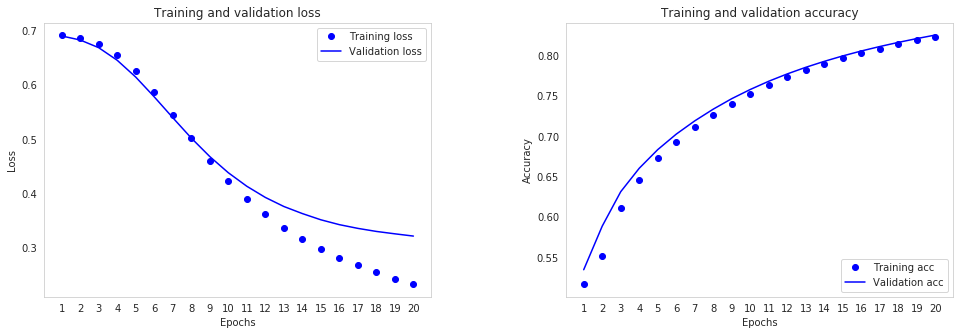

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86     12500
    Positive       0.86      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [183]:
class Embed(tf.keras.Model):
  def __init__(self, vocab_size, emb_size):
    super(Embed, self).__init__()
    self.emb_layer = tf.keras.layers.Embedding(vocab_size, emb_size)
    self.avg_layer = tf.keras.layers.GlobalAveragePooling1D()
    return

  def call(self, input_batch):
    intermediate_value = self.emb_layer(input_batch)
    output_batch = self.avg_layer(intermediate_value)
    return output_batch

class Prediction(tf.keras.Model):
  def __init__(self):
    super(Prediction, self).__init__()
    self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    intermediate_value = self.l1(input_batch)
    output_batch = self.l2(intermediate_value)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)


@tf.function
def train_batch(input_batch, labels_batch):
  # use global scope variables
  global model_embed, model_dens, model_optimizer
  with tf.GradientTape() as tape:
    preds_batch = model_embed(input_batch)
    preds_batch = model_dens(preds_batch)

    loss = loss_func(labels_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = model_embed.variables + model_dens.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc



def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global model
  y_pred = []
  y_true = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    preds_batch = model_embed(inputs_batch)
    preds_batch = model_dens(preds_batch)

    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
  return np.array(y_true), np.array(y_pred)

def classifier_dn(strings):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  for string in strings:
    encoding = text_encoder.encode(string)
    encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                             maxlen=MAX_LEN, 
                                                             padding='post', 
                                                             truncating='post', 
                                                             dtype='float32')
    preds = model_embed(encoding)
    preds = model_dens(preds)[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)

history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

with tf.device('/device:GPU:0'):
  
    model_embed = Embed(vocab_size=text_encoder.vocab_size, emb_size=EMBEDDING_SIZE)
    model_dens = Prediction()
    model_optimizer = tf.optimizers.Adam()
    model_metrics = tf.metrics.Accuracy()

    for epoch in range(EPOCHS):
      epoch_time = 0

      # train data
      loss_epoch = 0
      acc_epoch = 0

      for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
        start_time = time.time()
        # train on batch
        loss_batch, acc_batch = train_batch(encodings_batch, labels_batch)
        # keep track of loss and accuracy
        loss_epoch += loss_batch
        acc_epoch += acc_batch
        end_time = time.time()
        epoch_time += (end_time - start_time)
          
      batch_time = epoch_time / batch
      loss_epoch = tf.get_static_value(loss_epoch) / batch
      history_dict['loss'].append(loss_epoch)
      acc_epoch = tf.get_static_value(acc_epoch) / batch
      history_dict['accuracy'].append(acc_epoch)

      # validation data
      val_acc_epoch = 0
      val_loss_epoch = 0

      for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
        preds_batch = model_embed(encodings_bacth)
        preds_batch = model_dens(preds_batch)

        val_loss_epoch += loss_func(labels_batch, preds_batch)
        val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

      val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
      history_dict['val_loss'].append(val_loss_epoch)

      val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
      history_dict['val_accuracy'].append(val_acc_epoch)

      print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f\tTime epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                          EPOCHS, 
                                                                                                          loss_epoch, 
                                                                                                          acc_epoch, 
                                                                                                          val_loss_epoch, 
                                                                                                          val_acc_epoch,
                                                                                                          epoch_time,
                                                                                                          batch_time))    
plt_history(history_dict)

# evaluate
y_true, y_pred = model_predicitons(test_data.batch(5000))
print(classification_report(y_true, y_pred, target_names=list(ID_SENTIMENT.values())))

## Visualize

In [184]:
encoded_review, sentiment = next(iter(test_batches))

text_review = text_encoder.decode(encoded_review[0])
print('Review Sample:\n',text_review)
print('Sentiment: {}\n'.format(ID_SENTIMENT[int(sentiment[0])]))

explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

Review Sample:
 The strawberry blond has a great script, But I just wish Errol Flynn was in it instead of James Cagney, he's not the person for the part. I do think Olivia did a great job. This movie is also a day dream wrap around, so it's hard to follow. I don't like the male character attitude; the way Cagney presented it was just off. I give it a 3 for poor acting by main male character. ( If you like tough ruff men that like to fight all the time and argue then this is your movie). The Strawberry blond would have been better if the main character had more of a positve attitude, and change the script so he is happy he's with Oliva.<br /><br />THis movie points out Money does not bring happiness, women right jokes. Plain and simple not the best movie, but every one must decide for themselves.
Sentiment: Negative



/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Kmeans Clustering

In [0]:
# Embeddings

movies_reviews_embeddings = []
sentiments_reviews = []

data_generators = [train_batches, valid_batches, test_batches]
for data_generator in data_generators:
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
      batch_embeddings = model_embed(inputs_batch)
      [movies_reviews_embeddings.append(embedding) for embedding in tf.get_static_value(batch_embeddings)]
      [sentiments_reviews.append(sentiment) for sentiment in tf.get_static_value(labels_batch)]  
movies_reviews_embeddings = np.array(movies_reviews_embeddings)

## Find Best k-means

In [0]:
max_n_cluster = 10

### Elbow Method

For n_clusters = 2 Distortion is : 51.988677978515625
For n_clusters = 3 Distortion is : 34.89870071411133
For n_clusters = 4 Distortion is : 25.26406478881836
For n_clusters = 5 Distortion is : 21.148799896240234
For n_clusters = 6 Distortion is : 17.719327926635742
For n_clusters = 7 Distortion is : 15.699907302856445
For n_clusters = 8 Distortion is : 14.363042831420898
For n_clusters = 9 Distortion is : 12.704694747924805


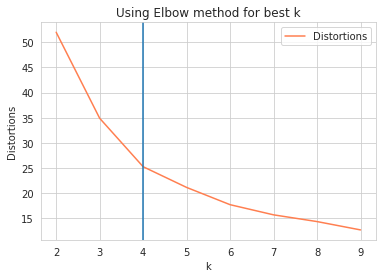

In [187]:
best_kmeans_elbow(features=movies_reviews_embeddings, n_clusters=max_n_cluster, verbose=True)

### Silhouette Method [time consuming]

For n_clusters = 2 The average silhouette_score is : 0.50501657
For n_clusters = 3 The average silhouette_score is : 0.39799586
For n_clusters = 4 The average silhouette_score is : 0.3925673
For n_clusters = 5 The average silhouette_score is : 0.3534837
For n_clusters = 6 The average silhouette_score is : 0.32861167
For n_clusters = 7 The average silhouette_score is : 0.3427101
For n_clusters = 8 The average silhouette_score is : 0.32603642
For n_clusters = 9 The average silhouette_score is : 0.33619043


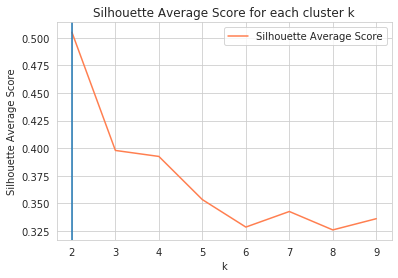

In [188]:
best_kmeans_silhouette(features=movies_reviews_embeddings, n_clusters=max_n_cluster)

### Best K model

In [0]:
best_k = 2

best_kmeans_labels, _ = kmeans(k=best_k, features=np.array(movies_reviews_embeddings))

### PCA Visualize

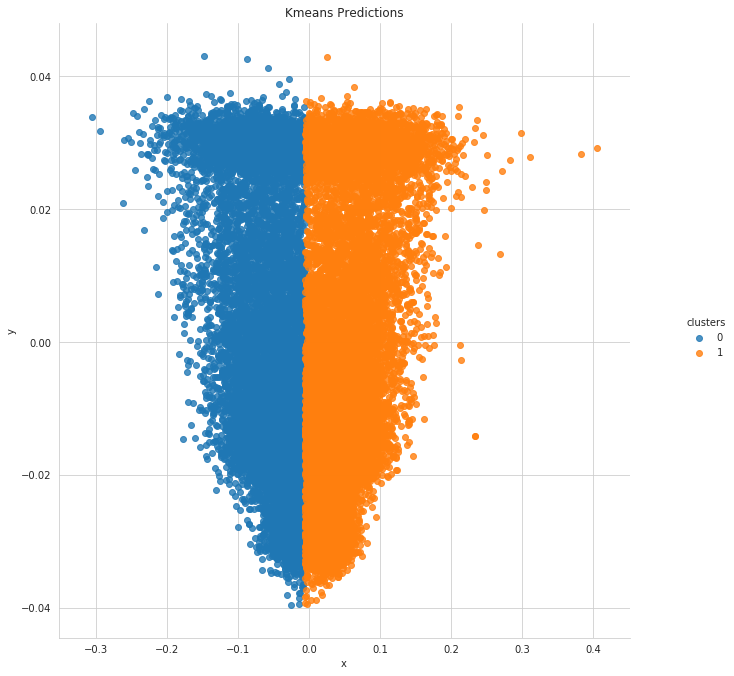

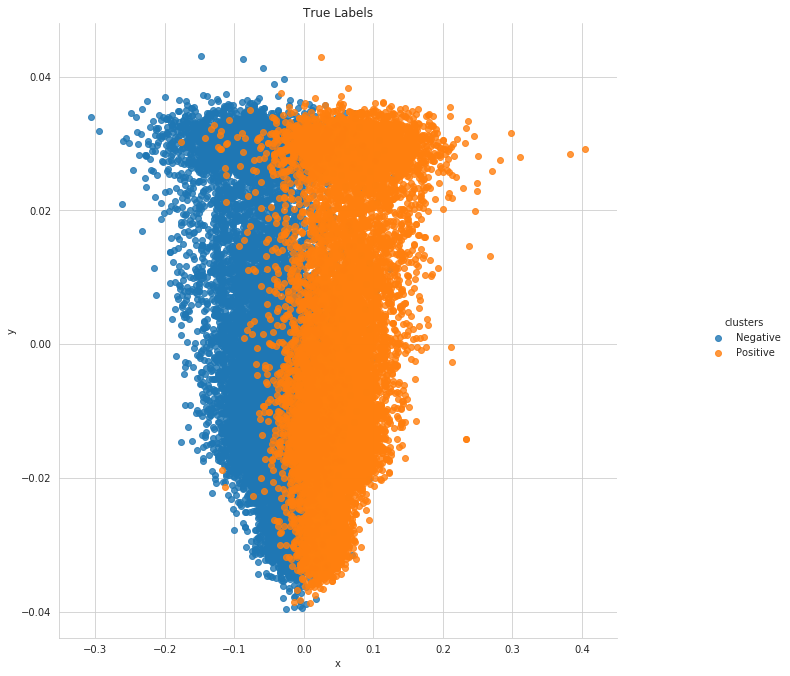



Found labels: [0, 1]



labels                  cluster_match
0  0       Negative:10902  Positive:768 
1  1       Positive:11732  Negative:1598

In [190]:
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

## K Means Sentiments

### k=3 sentiments

In [0]:
k_sentiments = 3

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

In [193]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels                 cluster_match
0  0       Negative:8161  Positive:214 
1  1       Positive:6330  Negative:4235
2  2       Positive:5956  Negative:104

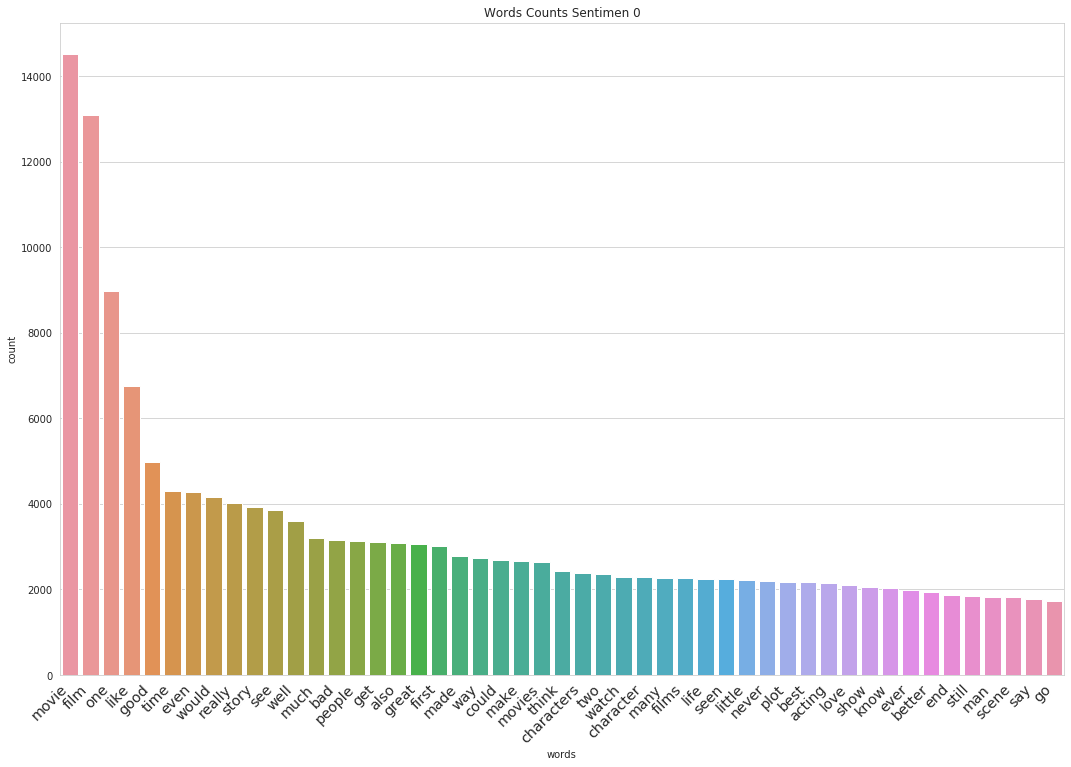

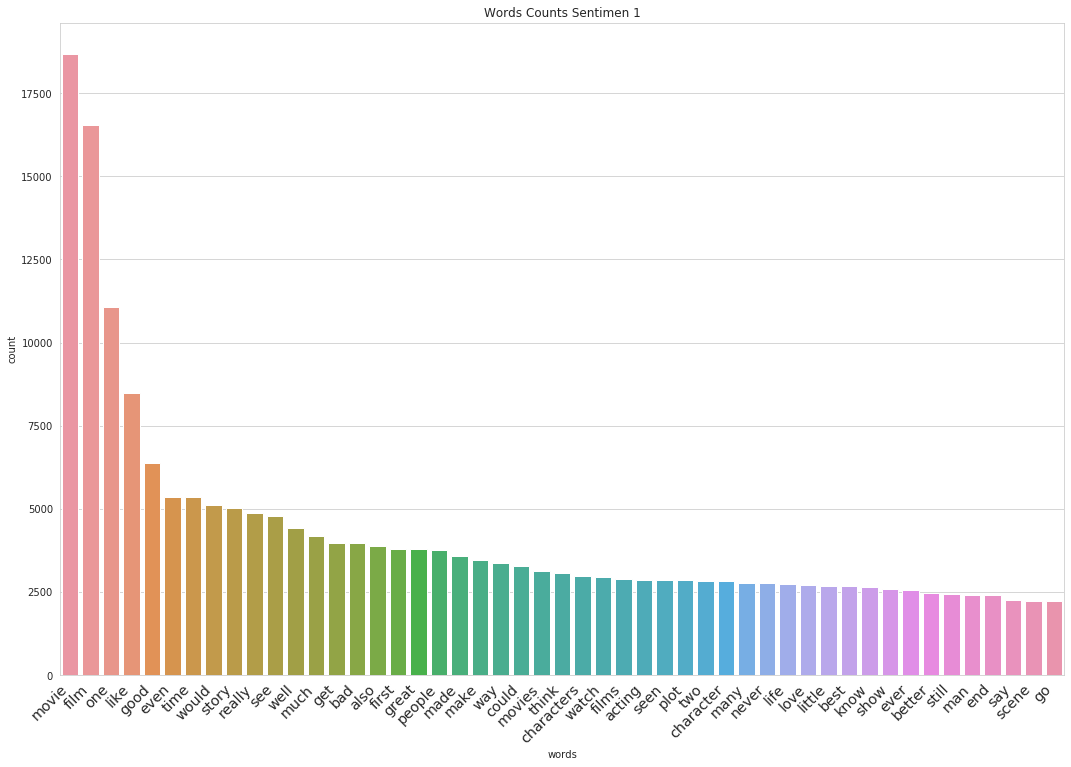

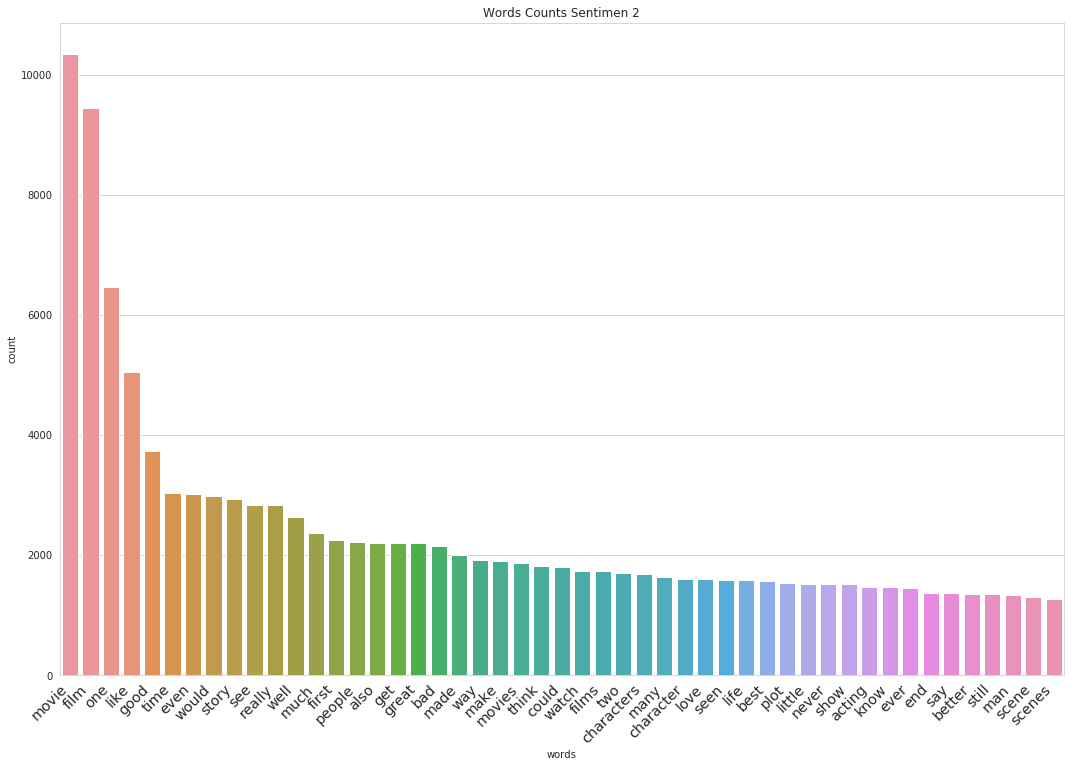

In [194]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

#### Visualize

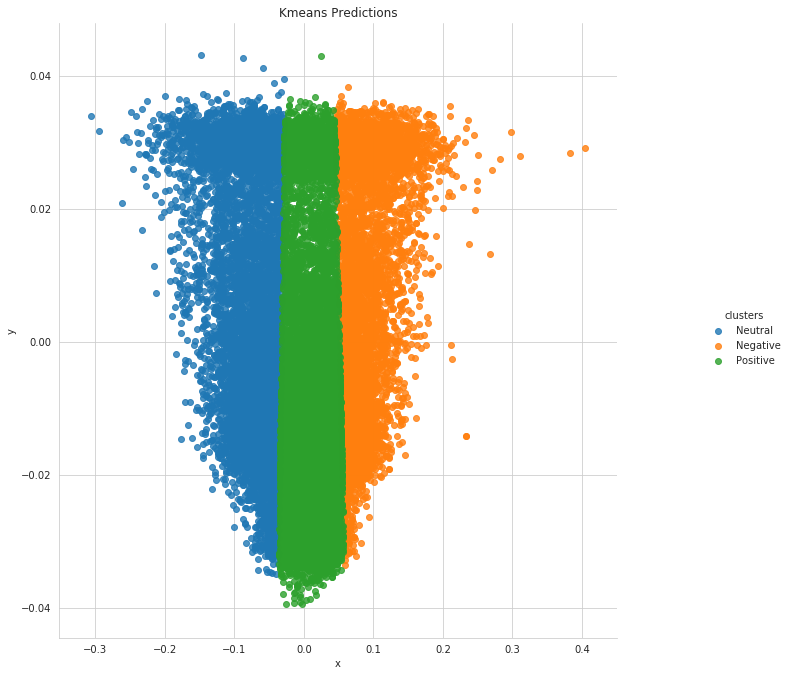

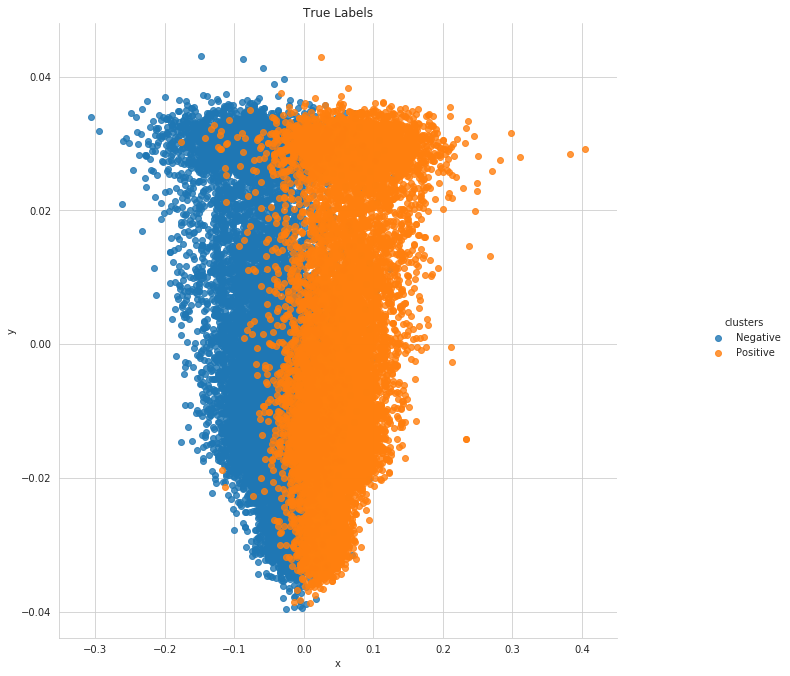

In [195]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [196]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=movies_reviews,
                        trues=sentiments_reviews, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  The movie has a great written genre story. It features all of the usual Columbo ingredients; The way Lt. Columbo approaches and bonds to his suspect, the way the mystery unravels for him, Columbo's dog, the cat and mouse play, which is great in this one and luckily as well some good relieving humor, mostly involving the Columbo character. It's all written despite the fact that it doesn't even have a truly original concept. Columbo hunting down a detective/murder novel writer had been done more than once before in a Columbo movie.<br /><br />It's also an extremely well directed movie from James Frawley, who after this directed 5 more Columbo movies, in the '70's and '80's. He provided the movie with style and some truly great and memorable sequences.<br /><br />It's one of the slower moving Columbo movies, despite not having a too long running time. This style and approach doesn't always work out well for a Columbo movie but in this movie it does, which is perhaps not in the least thanks to the acting performances of the movie.<br /><br />Most Columbo movie either starred a big well known star or a star from the early days of film-making, as the movie its murderer. This movie stars the rather unknown 81 year old Ruth Gordon. She didn't starred in an awful lot of movies throughout her career but she is still well known to some, mostly for her role in "Rosemary's Baby", which also won her an Oscar. She had a realistic and somewhat unusual style of acting, which some people might not like though. It earned her 4 more Oscar nominations throughout her career, prior to her win for "Rosemary's Baby", in 1969. She has some great interaction as well with Peter Falk in their sequences together.<br /><br />The movie also stars a still young G.D. Spradlin. I say young because I only know him from his latest productions out of his career, despite the fact that he already was 57 at the time of this Columbo production. He is still alive but retired from acting, ever since 1999.<br /><br />An even better than usual Columbo movie entry.<br /><br />8/10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ...  Neutral            
1  Japanese indie film with humor and philosophy where the three main characters run literally almost through the entire film, chasing each other due to strange circumstances and comical coincidence. As they are running, we see what is going on in their minds and how they got where they are at the moment. The act of running is a metaphor for these down-on-their luck people's lives. In some way, what they're really chasing for is not what they were originally chasing, but for meaning in their lives and an escape from their personal problems and broken dreams. Running makes them all feel truly alive. The big life-altering running adventure comes to an end when they accidentally get in the middle of something big, violent, and so absurd that it's funny in a clever way. One of my favorite films of all time by genius director Sabu.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [197]:
text_review = samples_df['Text'].values[2]

explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


### k=4 sentiments

In [0]:
k_sentiments = 4

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

In [200]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels                 cluster_match
0  0       Negative:3470  Positive:36  
1  1       Positive:8294  Negative:1019
2  2       Negative:7975  Positive:1118
3  3       Positive:3052  Negative:36

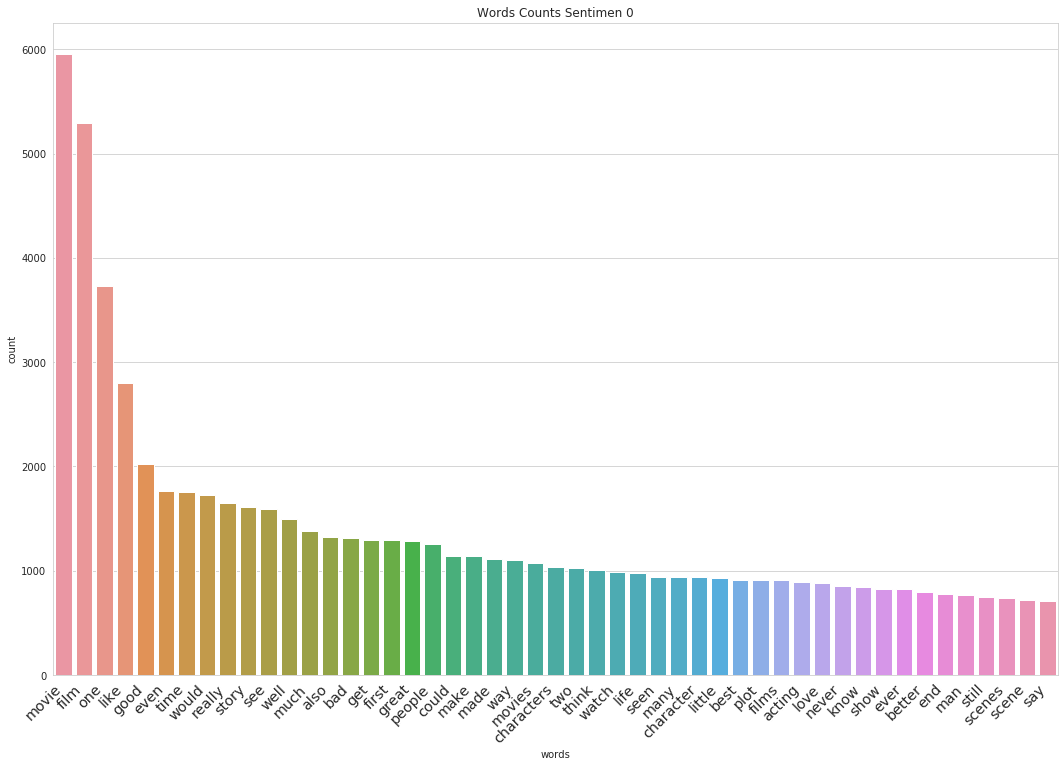

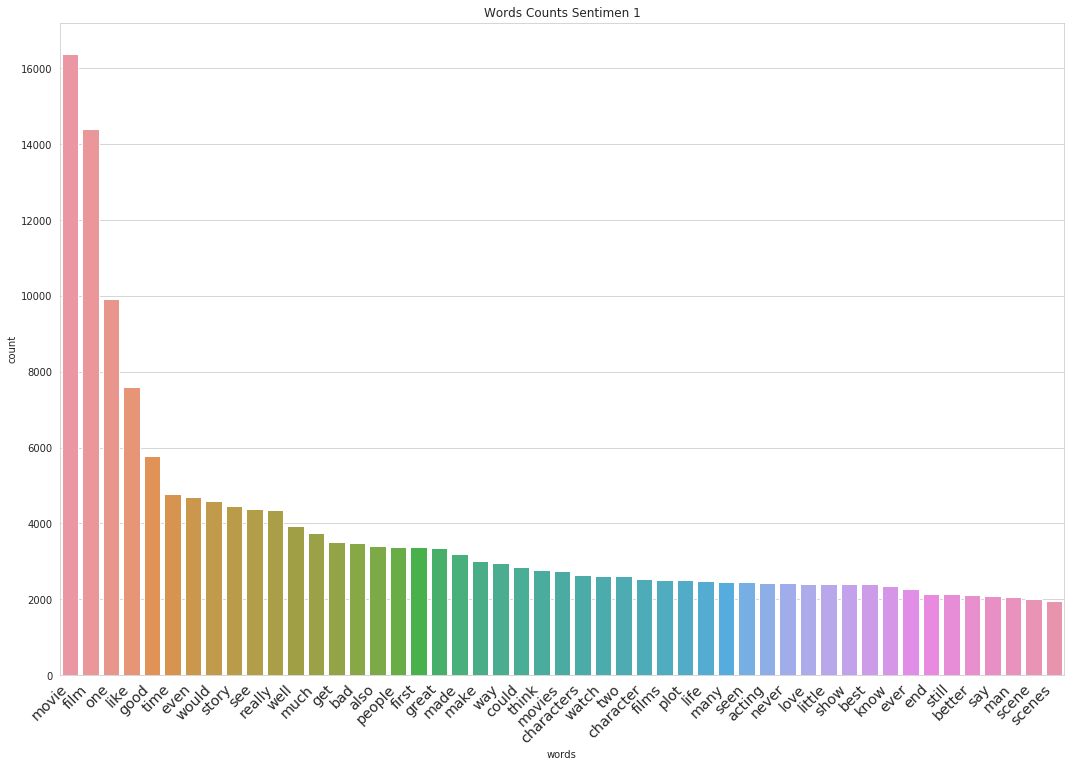

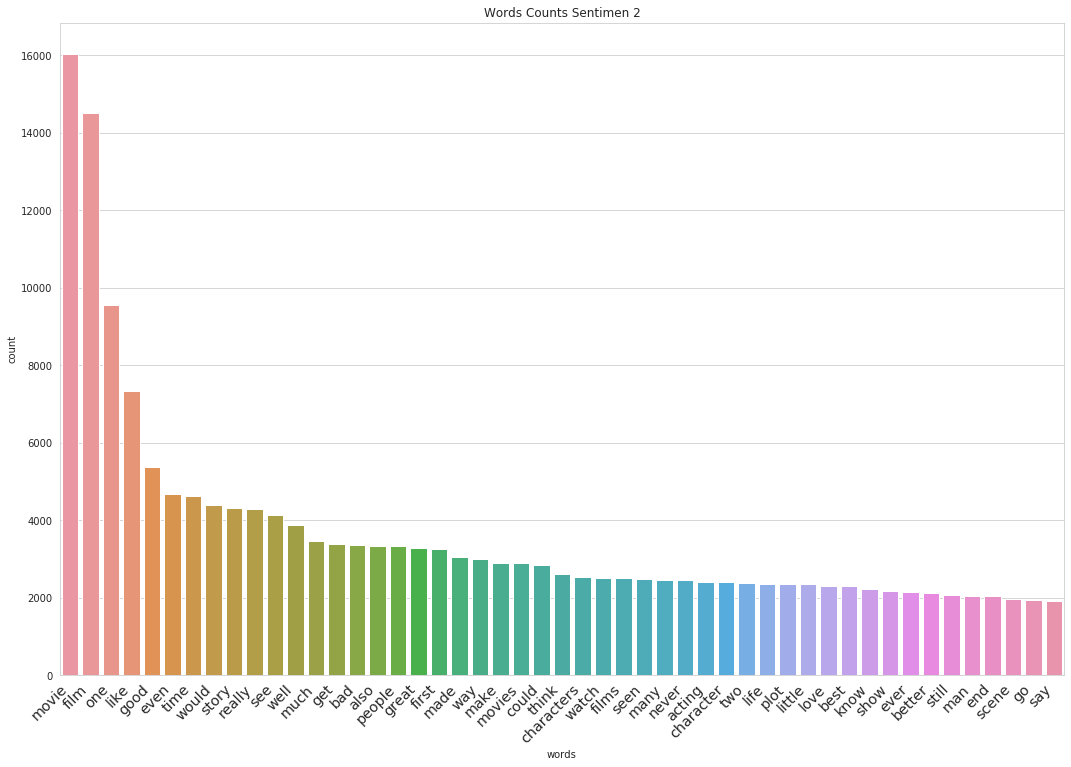

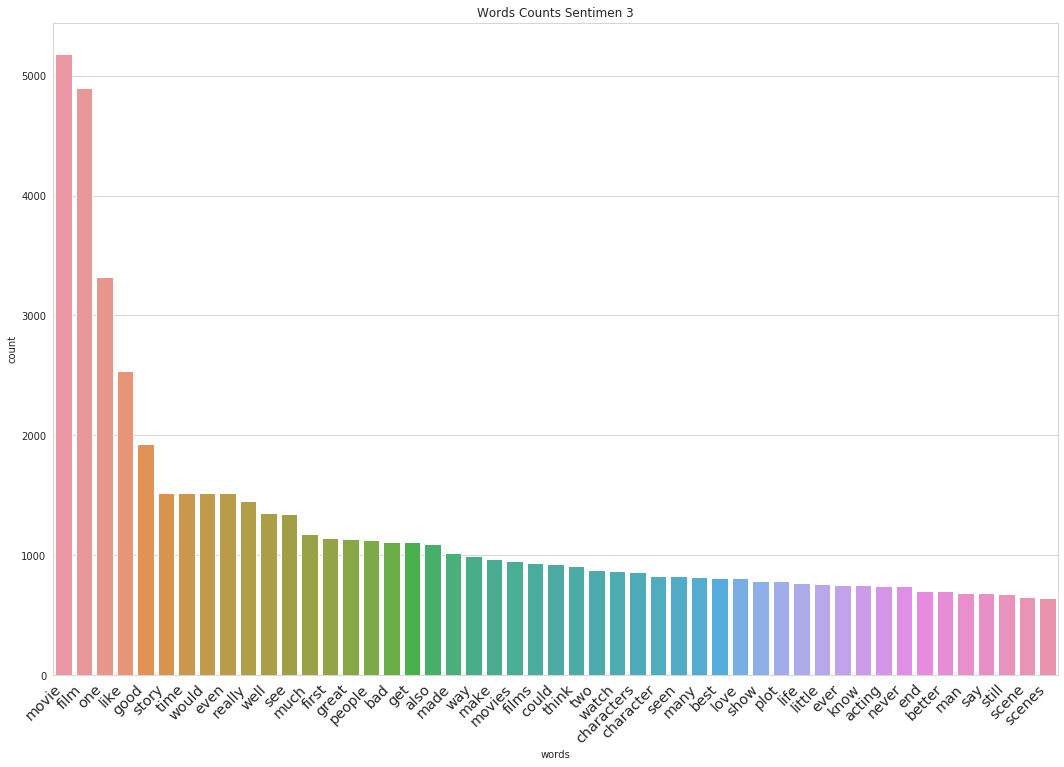

In [201]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

#### Visualize

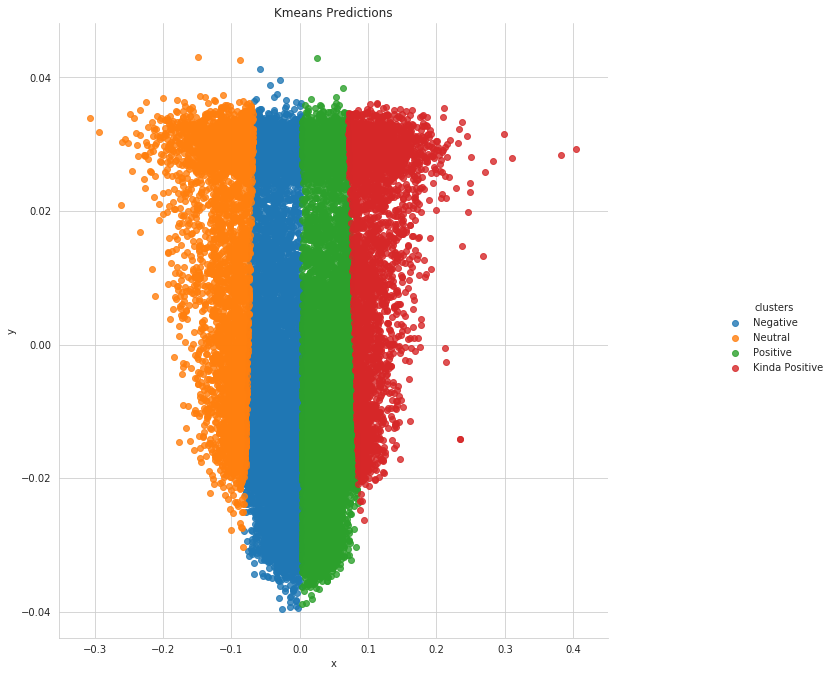

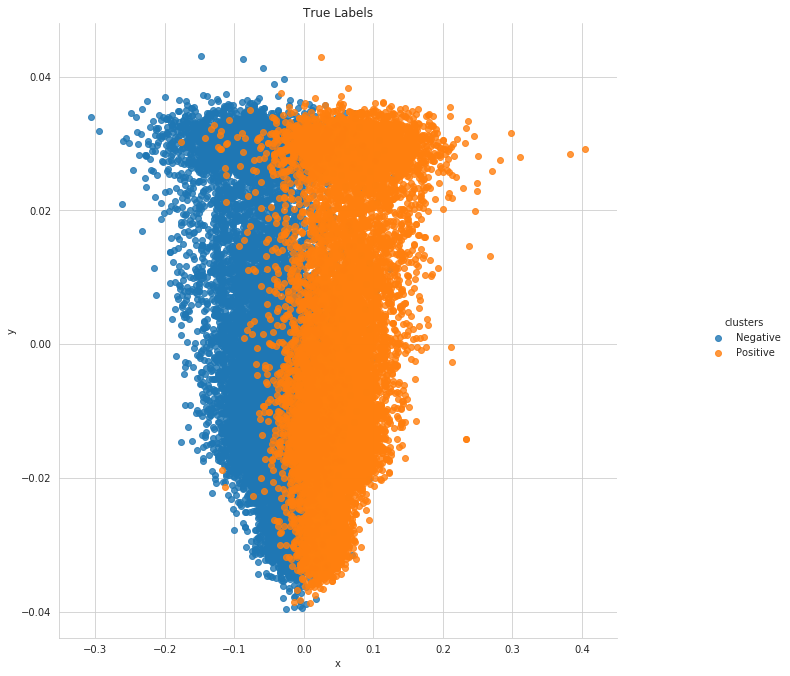

In [202]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [203]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=movies_reviews,
                        trues=sentiments_reviews, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  Astaire and Rogers at the height of their popularity. In 1936 Americans thought of the Navy as a place for song and dance. WWII was still a few years away. Fred and Ginger dance up the town.<br /><br />The plot is decent, but who cares... By the way, notice the cameo roles for Betty Grable and a glamorous Lucile Ball.<br /><br />A load of Irving Berlin songs, including the famous "Let's Face the Music and Dance". In that scene, Ginger's heavy swooping dress smacks Fred in the face during one of her spins and almost knocks him unconscious. Fred insisted on keeping the take as the dancing was superb nonetheless.<br /><br />Ginger once commented that she was a better dancer than Fred, since she had to do all the same moves, in step, and backwards...<br /><br />Come to think of it, Fred's voice was nice too. The man was effortless in motion.<br /><br />Here's a movie to cozy up on the couch with a loved-one, kick off the shoes, and enjoy the entertainment.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ...  Neutral            
1  I couldn't help but feel that this could have been a bigger movie than it was. The screenplay is highly intelligent and it just seemed that it could have been opened up in a way more reminiscent of Seven. Not by changing the story - I think mainly through the cinematography. The cinematography was the only thing that I found to be holding back the film. On the other hand, the pacing was absolutely on point. Whoever worked on the editing really did their job well. And I thought Bill Paxton did a great job of directing. Now away from the technical stuff...<br /><br />This movie threw me for a loop. SPOILER AHEAD!!!! All along, I really felt that Bill Paxton was crazy and then when Adam finally took the FBI agent to the Rose Garden to show him where the bodies were buried and revealed who he was, I got thrown for a loo

In [204]:
text_review = samples_df['Text'].values[2]

explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


## Custom Samples

In [205]:
custom_text = "GTC is the best conference I've ever been!"

encoding = text_encoder.encode(custom_text)
encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                       maxlen=MAX_LEN, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
embedding = model_embed(encoding)
kmean_label = kmean_model.predict(tf.get_static_value(embedding))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])


explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(custom_text,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

Text:  GTC is the best conference I've ever been!
Sentiment:  Positive


/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
